# Interactive 3D-Plot of Persistent Homology Simplicial Complexes from Attention

In [14]:
pip install plotly -q

Note: you may need to restart the kernel to use updated packages.


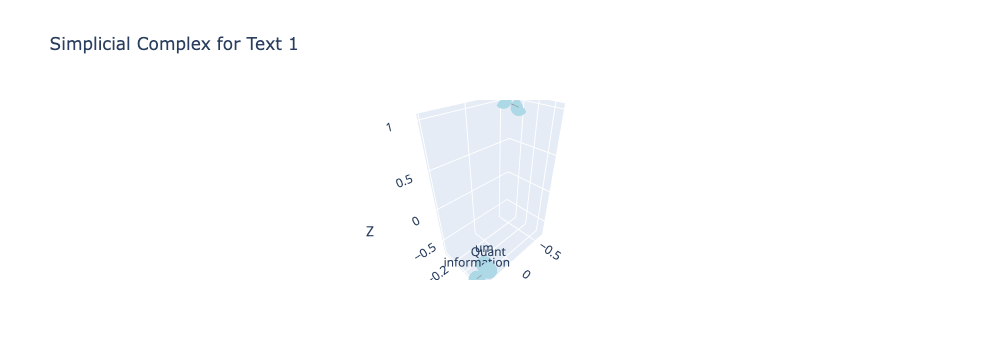

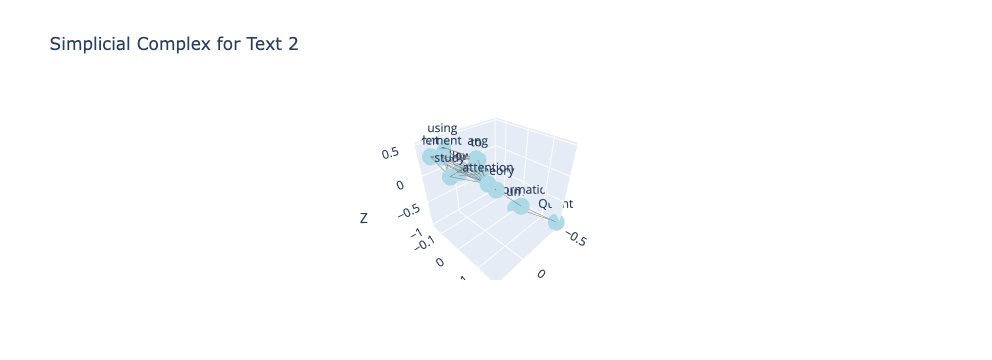

In [15]:
import numpy as np
import torch
from transformers import GPT2Tokenizer, GPT2Model
import gudhi as gd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import jensenshannon
import plotly.graph_objs as go


def get_attention_matrix(text, model, tokenizer, layer, head):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs, output_attentions=True)
    attention = outputs.attentions[layer][0, head].detach().cpu().numpy()
    return attention

def compute_persistence(attention_matrix):
    softmax_attention = np.exp(attention_matrix) / np.sum(np.exp(attention_matrix), axis=-1)[:, np.newaxis]
    distance_matrix = np.array([[jensenshannon(softmax_attention[i], softmax_attention[j]) for j in range(softmax_attention.shape[0])] for i in range(softmax_attention.shape[0])])
    
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=np.inf)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence(min_persistence=0.01)
    return persistence, simplex_tree, distance_matrix

def plot_simplicial_complex_3d(simplex_tree, distance_matrix, title, threshold, tokens):
    g = nx.Graph()
    for (simplex, _) in simplex_tree.get_filtration():
        if len(simplex) == 2:
            if distance_matrix[simplex[0]][simplex[1]] <= threshold:
                g.add_edge(simplex[0], simplex[1])

    # Create a token dictionary only for nodes in the graph
    labels = {node: tokens[node] for node in g.nodes()}
    
    # 3D layout
    pos = nx.spring_layout(g, dim=3, seed=42)
    
    # Extract node coordinates
    Xn = [pos[k][0] for k in g.nodes()]
    Yn = [pos[k][1] for k in g.nodes()]
    Zn = [pos[k][2] for k in g.nodes()]
    
    # Extract edge coordinates
    Xe = []
    Ye = []
    Ze = []
    for e in g.edges():
        Xe += [pos[e[0]][0], pos[e[1]][0], None]
        Ye += [pos[e[0]][1], pos[e[1]][1], None]
        Ze += [pos[e[0]][2], pos[e[1]][2], None]
    
    # Create a trace for edges
    trace_edges = go.Scatter3d(x=Xe, y=Ye, z=Ze, mode='lines', line=dict(color='gray', width=1))
    
    # Create a trace for nodes
    trace_nodes = go.Scatter3d(x=Xn, y=Yn, z=Zn, mode='markers+text', text=list(labels.values()), marker=dict(symbol='circle', size=10, color='lightblue'), textposition="top center")
    
    # Create a layout
    layout = go.Layout(title=title, scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'), showlegend=False)
    
    # Create a plot
    fig = go.Figure(data=[trace_edges, trace_nodes], layout=layout)
    fig.show()


# Load pre-trained transformer model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

# Text inputs
text1 = "Quantum information theory is interesting"
text2 = "Quantum information theory allows us to study attention using entanglement"

# Choose a layer and head
layer = 1
head = 2

# Get attention matrices
attention_matrix1 = get_attention_matrix(text1, model, tokenizer, layer, head)
attention_matrix2 = get_attention_matrix(text2, model, tokenizer, layer, head)

# Compute persistence and simplex trees
persistence1, simplex_tree1, distance_matrix1 = compute_persistence(attention_matrix1)
persistence2, simplex_tree2, distance_matrix2 = compute_persistence(attention_matrix2)

# Threshold value
threshold = 0.05

# Get tokens
tokens1 = tokenizer.tokenize(text1)
tokens2 = tokenizer.tokenize(text2)

# Add special tokens ([CLS], [SEP], etc.) if necessary
tokens1 = [tokenizer.decode(token_id) for token_id in tokenizer.encode(text1)]
tokens2 = [tokenizer.decode(token_id) for token_id in tokenizer.encode(text2)]

plot_simplicial_complex_3d(simplex_tree1, distance_matrix1, "Simplicial Complex for Text 1", threshold, tokens1)
plot_simplicial_complex_3d(simplex_tree2, distance_matrix2, "Simplicial Complex for Text 2", threshold, tokens2)


### Prompter: 
Referencing the code above, could you please ellaborate on the nature of graph grammars on the $1$-skeleton of the simplicial complexes obtained from the persistent homology of the Jensen-Shannon distance between the softmax of the attention mechanism applied to two input texts. 
The graph grammar, in this context, refers to the set of rules and operations that describe how the graph structure, representing the 1-skeleton of the simplicial complex, is formed and how it evolves. The 1-skeleton of a simplicial complex is essentially the set of vertices and edges, without higher-dimensional simplices (like triangles or tetrahedra). In the code above, we obtain the 1-skeleton of the simplicial complex by constructing a graph from the simplex tree based on a threshold value for the distance matrix.

### ChatGPT:
The graph is generated from the Jensen-Shannon (JS) distance between the softmax of the attention mechanism applied to two input texts. The JS distance measures the similarity between two probability distributions, in this case, the softmax distributions of attention weights. By calculating the pairwise JS distance between all attention distributions, a distance matrix is formed. The distance matrix is then used to construct a Rips complex using the GUDHI library. The Rips complex is a simplicial complex that represents the topological structure of the data.

Persistent homology is used to identify and quantify the topological features of the simplicial complex that persist across multiple distance scales. In the code, the persistence value is set to 0.01, which filters out short-lived topological features.

To obtain the 1-skeleton, a graph is created by iterating through the filtration of the simplex tree and adding edges between vertices if their corresponding JS distance is less than or equal to the chosen threshold. The graph's nodes represent the tokens in the input text, and the edges represent the relationships between the tokens based on the attention mechanism's softmax output.

The graph grammar, in this case, depends on the threshold value applied to the JS distance matrix. A lower threshold value will result in a sparser graph with fewer edges, while a higher threshold will produce a denser graph with more connections between tokens. The resulting graph structure can be used to study the relationships between tokens in the text, as captured by the attention mechanism of the transformer model.

In summary, the graph grammar for the 1-skeleton of the simplicial complex is determined by the threshold applied to the distance matrix, which is derived from the JS distance between the softmax of the attention mechanism applied to the input texts. The graph structure represents the relationships between tokens in the text based on the attention mechanism's output and can provide insights into the underlying structure and organization of the text.

---
This isn't exactly the response I was looking for, but it's summary of what the code doesa. There relly isn't a good explanation of how graph grammars can be used in this context that I have found though.